Testing `mushi` with `stdpopsim` simulations
==

In [1]:
import mushi
import mushi.composition as cmp

import msprime
import stdpopsim
from IPython.display import SVG
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from scipy.special import expit
import time

## Time grid

In [2]:
change_points = np.logspace(0, np.log10(100000), 100)
t = np.concatenate((np.array([0]), change_points))

## Sawtooth demographic history $\eta(t)$

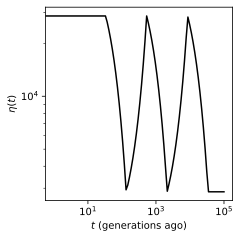

In [3]:
species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("Zigzag_1S14")
ddb = model.get_demography_debugger()
eta_true = mushi.eta(change_points, 2 * ddb.population_size_trajectory(steps=t)[:, 0])

plt.figure(figsize=(3.5, 3.5))
eta_true.plot(c='k')
plt.show()

## Mutation rate history $\mu(t)$
A 96 dimensional history with a mixture of two latent signature: constant and pulse.

/Users/williamdewitt/Applications/miniconda2/envs/mushidocs/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


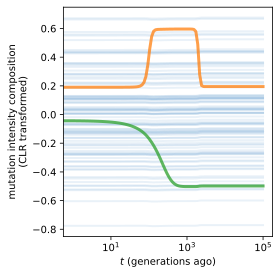

In [4]:
flat = np.ones_like(t)
pulse = expit(.1 * (t - 100)) - expit(.01 * (t - 2000))
ramp = expit(-.01 * (t - 100)) 
n_mutation_types = 96
Z = np.zeros((len(t), n_mutation_types))
mu0 = 1
np.random.seed(0)

Z[:, 0] = mu0 * (1 * flat + .5 * pulse)

Z[:, 1] = mu0 * (.5 * flat + .4 * ramp)

for col in range(2, n_mutation_types):
    scale = np.random.lognormal(-.2, .3)
    pulse_weight = 5 if col == 0 else 0
    Z[:, col] = mu0 * scale * flat

mu_true = mushi.mu(change_points, Z)

plt.figure(figsize=(4, 4))
mu_true.plot(range(2, n_mutation_types), alpha=0.1, lw=2, c='C0', clr=True)
mu_true.plot((0,), alpha=0.75, lw=3, c='C1', clr=True)
mu_true.plot((1,), alpha=0.75, lw=3, c='C2', clr=True)
plt.show()

Estimate constant total mutation rate using most recent time point (introducing a misspecification)

In [5]:
mu0 = mu_true.Z[0, :].sum()
print(mu0)

83.11894862750988


## `stdpopsim` simulation
- 200 sampled haplotypes
- generate initial tree sequence without mutations, then we'll place mutations according to the MuSH

In [6]:
n = 200
chrom = 22
species = stdpopsim.get_species('HomSap')
contig = species.get_contig(f'chr{chrom}')
contig = stdpopsim.Contig(recombination_map=contig.recombination_map, mutation_rate=0, genetic_map=contig.genetic_map)
model = stdpopsim.PiecewiseConstantSize(eta_true.y[0] / 2, *zip(change_points, eta_true.y[1:] / 2))
samples = model.get_samples(n)
engine = stdpopsim.get_default_engine()
ts = engine.simulate(model, contig, samples, mutation_rate=0)

Number of marginal trees

In [7]:
ts.num_trees

64851

Display first tree in the tree sequence

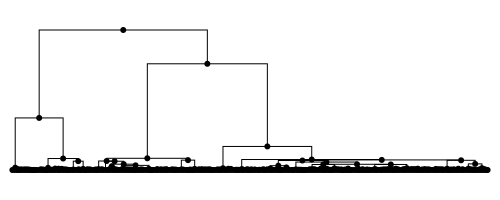

In [8]:
SVG(ts.first().draw(format='svg', width=500, height=200,
                    node_labels={}, mutation_labels={}))

## Simulate $k$-SFS
- place mutations on simulated tree sequence according to $\boldsymbol\mu(t)$
- iterate over mutation types and epochs
- compute component of $k$-SFS for each iterate

In [9]:
X = np.zeros((n - 1, n_mutation_types))
for start_time, end_time, mutation_rate in mu_true.epochs():
    mutation_rate_total = mutation_rate.sum()
    print(f'epoch boundaries: ({start_time:.2f}, {end_time:.2f}), μ: {mutation_rate_total:.2f}     ',
          flush=True, end='     \r')
    # note: the factor of 1 / chrom.length is needed to scale the mutation rate from sites to genomes
    ts_temp = msprime.mutate(ts,
                             rate=mutation_rate_total / species.genome.chromosomes[chrom - 1].length,                                   
                             start_time=start_time,
                             end_time=end_time,
                             random_seed=1,
                             keep=True)
    for var in ts_temp.variants():
        i = var.genotypes.sum() - 1
        j = np.random.choice(n_mutation_types, p=(mutation_rate / mutation_rate_total))
        X[i, j] += 1
        
ksfs = mushi.kSFS(X=X)

epoch boundaries: (9.11, 10.24), μ: 83.11     

Plot SFS and $k$-SFS

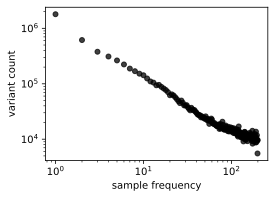

In [10]:
plt.figure(figsize=(4, 3))
ksfs.plot_total(kwargs=dict(ls='', marker='o', ms=5, c='k', alpha=0.75),
                line_kwargs=dict(c='C0', alpha=0.75, lw=3),
                fill_kwargs=dict(color='C0', alpha=0.1))
plt.xscale('log')
plt.yscale('log')

plt.figure(figsize=(4, 3))
ksfs.plot(range(2, n_mutation_types), clr=True, kwargs=dict(alpha=0.1, ls='', marker='.', c='C0'))
ksfs.plot((0,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C1'))
ksfs.plot((1,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C2'))
plt.show()

Number of segregating sites

In [11]:
ksfs.X.sum()

8300725.0

TMRCA CDF

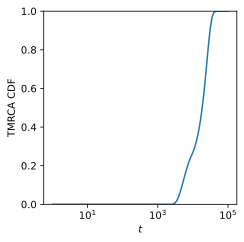

In [12]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(change_points, ksfs.tmrca_cdf(eta_true))
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('log')
plt.tight_layout()
plt.show()

## Infer $\eta(t)$ and $\boldsymbol\mu(t)$

Define regularization parameters and convergence criteria. We use a tolerance of zero and a very large number of iterations.

In [13]:
convergence = dict(tol=1e-16, max_iter=10000)
regularization_eta = dict(alpha_tv=2e0, alpha_spline=1e3, alpha_ridge=1e-10)
regularization_mu = dict(beta_rank=2e1, beta_tv=1e2, beta_spline=1e3, beta_ridge=1e-10)

Clear out histories (just in case) and run inference

In [14]:
ksfs.clear_eta()
ksfs.clear_mu()

ksfs.infer_history(change_points, mu0,
                   **regularization_eta, **regularization_mu, **convergence)

inferring η(t)


initial objective -8.994664e+07


iteration 80, objective -9.005e+07, relative change 1.032e-07

iteration 93, objective -9.005e+07, relative change 4.053e-08

iteration 94, objective -9.005e+07, relative change 3.989e-08

iteration 206, objective -9.005e+07, relative change 8.680e-09

iteration 798, objective -9.005e+07, relative change 1.415e-11

iteration 1051, objective -9.005e+07, relative change 2.538e-12

iteration 1229, objective -9.005e+07, relative change 4.278e-12

iteration 3271, objective -9.005e+07, relative change 4.961e-13

## Plot results

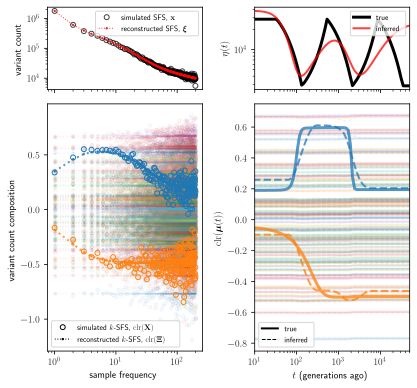

In [15]:
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', figsize=(5.9, 5.5), gridspec_kw={'height_ratios': [1, 3]})

plt.sca(axes[0, 0])
ksfs.plot_total(kwargs=dict(ls='', alpha=0.75, marker='o', ms=5, mfc='none', c='k', label=r'simulated SFS, $\mathbf x$'),
                line_kwargs=dict(c='r', ls=':', marker='.', ms=3, alpha=0.75, lw=1, label=r'reconstructed SFS, $\boldsymbol{\xi}$'),
                fill_kwargs=dict(alpha=0))
plt.yscale('log')
plt.xlabel(None)
plt.legend(fontsize=8)

plt.sca(axes[1, 0])
ksfs.plot(range(2, n_mutation_types), clr=True, kwargs=dict(alpha=0.1, ls='', marker='o', ms=3, mfc='none', rasterized=True),
          line_kwargs=dict(ls=':', marker='.', ms=2, alpha=0.1, lw=1, rasterized=True))
ksfs.plot((0,), clr=True, kwargs=dict(ls='', marker='o', ms=5, mfc='none', c='C0'),
          line_kwargs=dict(ls=':', marker='.', ms=3, alpha=0.75, lw=2, c='C0'))
ksfs.plot((1,), clr=True, kwargs=dict(ls='', marker='o', ms=5, mfc='none', c='C1'),
          line_kwargs=dict(ls=':', marker='.', ms=3, alpha=0.75, lw=2, c='C1'))
plt.ylabel('variant count composition')
legend_elements = [Line2D([0], [0], ls='', marker='o', ms=5, mfc='none', color='k', label=r'simulated $k$-SFS, $\mathrm{clr}(\mathbf X)$'),
                   Line2D([0], [0], ls=':', marker='.', color='k', ms=3, lw=1, label=r'reconstructed $k$-SFS, $\mathrm{clr}(\boldsymbol\Xi)$')]
plt.legend(handles=legend_elements, loc='lower left', fontsize=8)

plt.sca(axes[0, 1])
eta_true.plot(c='k', alpha=1, lw=3, label='true')
ksfs.eta.plot(c='r', alpha=0.75, lw=2, label='inferred')
plt.legend(fontsize=8, loc='upper right')
plt.xlabel(None)

plt.sca(axes[1, 1])
mu_true.plot(range(2, n_mutation_types), alpha=0.2, lw=2, rasterized=True, clr=True)
plt.gca().set_prop_cycle(None)
ksfs.mu.plot(range(2, n_mutation_types), alpha=0.1, lw=1, ls='--', rasterized=True, clr=True)
mu_true.plot((0,), alpha=0.75, lw=3, c='C0', clr=True)
ksfs.mu.plot((0,), alpha=0.75, lw=2, c='C0', clr=True, ls='--')
mu_true.plot((1,), alpha=0.75, lw=3, c='C1', clr=True)
ksfs.mu.plot((1,), alpha=0.75, lw=2, c='C1', clr=True, ls='--')
plt.ylabel(r'$\mathrm{clr}(\boldsymbol{\mu}(t))$')
legend_elements = [Line2D([0], [0], color='k', lw=2, label='true'),
                   Line2D([0], [0], color='k', ls='--', lw=1, label='inferred')]
plt.legend(handles=legend_elements, loc='lower left', fontsize=8)
plt.xlim([1e1, 5e4])

plt.tight_layout();